# Kernel Estimator Challenge

In this challenge, you will use [Pennylane](https://github.com/PennyLaneAI/pennylane) and [Amazon Braket](https://github.com/aws/amazon-braket-examples) to implement a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Complete each of the four TODOs in this notebook to construct and train a QML model to solve the binary classification task. You can use the `gen_binary.py` script to generate a new train/test dataset, and further test your model.

A central feature of Amazon Braket is that its remote simulator can execute multiple circuits in parallel. This capability can be harnessed in PennyLane during circuit training, which requires lots of variations of a circuit to be executed. Hence, the PennyLane-Braket plugin provides a method for scalable optimization of large circuits with many parameters. After validating your implementation and successfully training using a local simulator, enable [qBraid quantum jobs](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html) and test your binary classifier on remote quantum hardware using the [Amazon Braket Pennylane plugin](https://github.com/aws/amazon-braket-pennylane-plugin-python). See the resources linked below for more.

*Important*:  Your final model must be tested with on a remote quantum device using the Amazon Braket Pennylane plugin. Submissions that do not interface with [Amazon Braket supported devices](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html) will not be eligible to be ranked on the leaderboard.

#### Pennylane Resources:

- [Quantum Embedding](https://pennylane.ai/qml/glossary/quantum_embedding.html)
- [Quantum Feature Map](https://pennylane.ai/qml/glossary/quantum_feature_map.html)
- [Circuit Ansatz](https://pennylane.ai/qml/glossary/circuit_ansatz.html)
- [Variational Circuit](https://pennylane.ai/qml/glossary/variational_circuit.html)
- [Quantum Gradient](https://pennylane.ai/qml/glossary/quantum_gradient.html)
- [Variational Quantum Classifier](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)
- [PennyLane-Braket Plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/)
- [Computing gradients in parallel with Amazon Braket](https://pennylane.ai/qml/demos/braket-parallel-gradients.html)

#### Amazon Braket Resources:

- [Use PennyLane with Amazon Braket](https://docs.aws.amazon.com/braket/latest/developerguide/hybrid.html)
- [Amazon Braket examples: hybrid quantum algorithms](https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_quantum_algorithms)

#### qBraid Resources:

- [qBraid demo notebooks: quantum jobs](https://github.com/qBraid/qbraid-lab-demo/blob/main/qbraid_quantum_jobs.ipynb)
- [qBraid CLI: quantum jobs commands](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/cli/jobs.html)

In [1]:
# !qbraid jobs enable haqs  # enable quantum jobs

In [2]:
TEAM_NAME = "template"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [4]:
from scipy.stats import unitary_group
from scipy.optimize import minimize
from numpy import mgrid

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Load and visualize dataset

To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

This binary dataset has been artificially generated to be perfectly classifiable using a suitable feature map.

In [5]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [49]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

k_dim = 30
n_samples = k_dim * 2
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size=0.5)

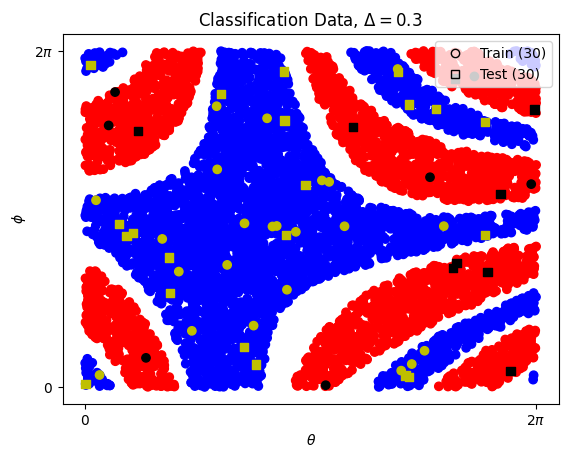

In [50]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.savefig(DATA_PATH + "binary_landscape.png")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

## Quantum Kernel Estimation

In [51]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

### Feature mapping functions

In [52]:
def feature_map(x, meas=False):
    """Short depth feature map with entanglement
    
    Args:
        x : shape (3,) tensor containing one encoded data vector
        meas : boolean where `True` prompts a probabilistic measurement at the end of the circuit 

    Returns:
        (iff `meas = True`) shape (2,) tensor containing probability of each computational basis state
    """
    
    # apply series of Hadamards and diagonal phase gate compoenents
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RX(x[0], wires=0) 
        qml.RX(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(x[2], wires=1)
        qml.CNOT(wires=[0, 1])
    
    if meas:
        return qml.probs(wires=[0,1])

In [53]:
def feature_map_adjoint(x):
    """Complex congugate of feature_map in reverse.
    See Havlicek supplemental figure 5b"""
    
    for _ in range(2):
        
        # Unitary of Phi(x)
        qml.RX(-x[0], wires=0)
        qml.RX(-x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(-x[2], wires=1)
        qml.CNOT(wires=[0, 1])
        
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)

In [72]:
shots = 500
n_wires = 2
dev = qml.device("default.qubit", wires=n_wires, shots=shots)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1

@qml.qnode(dev)
def kernel(x, z):
    """The quantum kernel."""
    
    feature_map(encode_data(x))
    feature_map_adjoint(encode_data(z))
    
    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [73]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [74]:
@qml.qnode(dev)
def fidelity_estimate(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`
    
    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector
    
    Returns:
        shape (2, `R`) tensor containing `R` Z-basis measurement samples on each qubit, where `R` 
        is the number of shots determined from the dev.shots attribute of the corresponding device.
    """
    
    feature_map(x)
    feature_map_adjoint(z)
    
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

In [75]:
def qubit_wise(result):
    n, R  = result.shape
    new_result = np.zeros((R, n))
    for i in range(R):
        for j in range(n):
            new_result[i][j] = result[j][i]
    return new_result

In [76]:
def measure_zeros(x, z, R, n):
    """Evaluates measurement outcome of `fidelity_estimate` circuit on given inputs
    
    Args:
    
    Returns:
    
    """

    count = 0
    result = qubit_wise(fidelity_estimate(x, z))
    assert R, n == result.shape
    zeros = np.array([-1]*n)  # qml.sample returns {-1,+1} instead of {0,1}
    
    for i in range(R):
        var = np.tensordot(result[i], zeros, axes=1).item() / n
        count += var if var == 1.0 else 0.0
    
    return count

In [77]:
def kernel_experimental(T, S, R=shots):
    """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets T and S. 
    If T = S this is the Gram matrix.
    
    Args:
    
    Returns:
    
    """
    t, n = T.shape
    s, m = S.shape
    assert n == m
    Kernel = np.zeros((t,s))
    
    # create inner product space with input matrix T
    for i in range(t):
        for j in range(s):
            x, z = encode_data(T[i]), encode_data(S[j])
            count = measure_zeros(x, z, R, n)
            Kernel[i,j] = count
               
    return Kernel / R

## Kernel Visualization

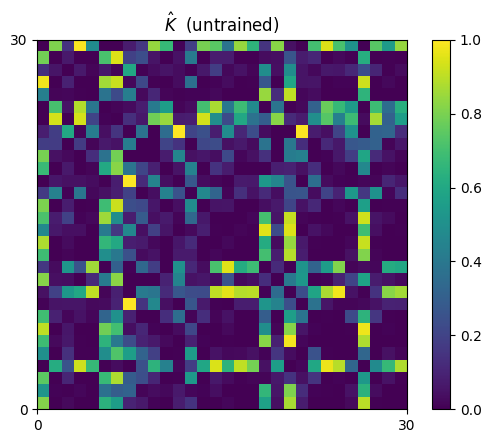

In [85]:
kernel_ex = kernel_experimental(X_train, X_train)

im = plt.imshow(kernel_ex, extent=(0, k_dim, 0, k_dim))
plt.colorbar(im)
plt.xticks([0, k_dim])
plt.yticks([0, k_dim])
plt.title("$\hat{K}$  (untrained)")
plt.show()

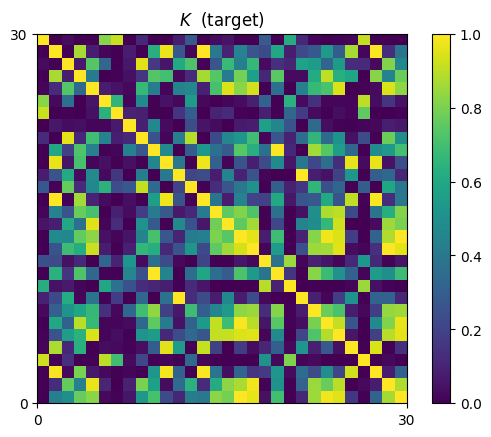

In [86]:
kernel_th = kernel_matrix(X_train, X_train)

im = plt.imshow(kernel_th, extent=(0, k_dim, 0, k_dim))
plt.colorbar(im)
plt.xticks([0, k_dim])
plt.yticks([0, k_dim])
plt.title("$K$  (target)")
plt.show()

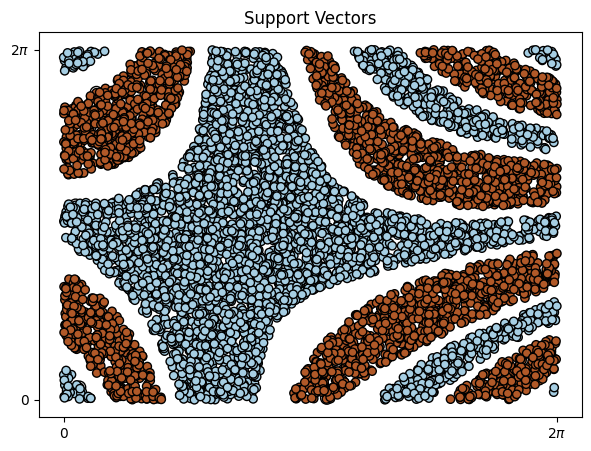

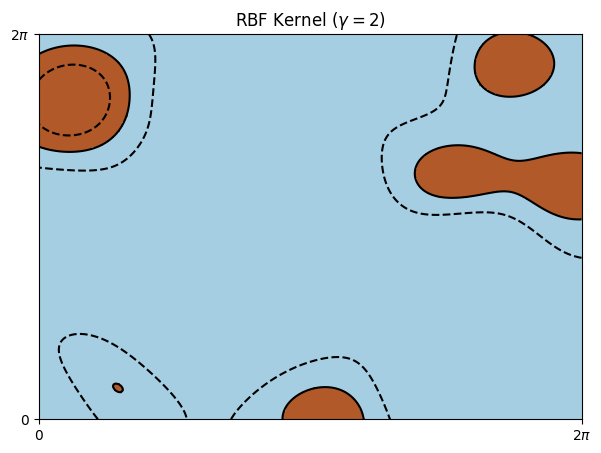

In [87]:
# fit the model
kernel = 'rbf'
gamma = 2
clf = SVC(kernel=kernel, gamma=gamma)
clf.fit(X_train, Y_train)

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(7, 5))
plt.clf()

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,  
            facecolors='none', zorder=10, edgecolors='k')
plt.scatter(Xs[:, 0], Xs[:, 1], c=Ys, zorder=10, cmap=plt.cm.Paired, 
            edgecolors='k')

x_min, x_max = 0, 2*np.pi
y_min, y_max = 0, 2*np.pi

XX, YY = mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

plt.xticks([x_min, x_max], [r'$0$', r'$2\pi$'])
plt.yticks([y_min, y_max], [r'$0$', r'$2\pi$'])

plt.title("Support Vectors")

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(figsize=(7, 5))
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks([x_min, x_max], [r'$0$', r'$2\pi$'])
plt.yticks([y_min, y_max], [r'$0$', r'$2\pi$'])
plt.title("RBF Kernel ($\gamma = ${})".format(gamma))
plt.show()

## Training

In [92]:
def loss(Ys, Khat):
    
    t = len(Ys)
    
    def loss_(alpha):
        
        s = 0
        for i in range(t):
            for j in range(t):
                s += Ys[i]*Ys[j]*alpha[i]*alpha[j]*Khat[i,j]
        s = np.sum(alpha) - 0.5*s
        
        return 1./s  # returning the inverse so we can minimize instead of maximize
    
    return loss_

In [93]:
def train(Y_train, Khat):
    
    t = len(Y_train)
    a0 = np.random.rand(t)         # randomly initialize Lagrange multipliers (alphas)
    loss_fn = loss(Y_train, Khat)  # lambda function to compute loss with alphas
    
    # Inequality constraint function result is to be non-negative
    # Equality constraint function result is to be zero 
    cons = ({'type': 'ineq', 'fun': lambda alpha: alpha},
            {'type': 'eq', 'fun': lambda alpha: np.sum(alpha*Y_train)})
    
    res = minimize(loss_fn, 
               a0, constraints=cons, 
               method='SLSQP', 
               #options={'maxiter': 1000,}
    )
    
    alpha = np.array(res['x'])  # optimized alphas
    
    supports = [i for i in range(t) if not np.isclose(alpha[i],0)] # any index of alpha where alpha_i* > 0
    b = Y_train[supports[0]] - np.sum(Y_train * alpha * Khat[supports[0],:]) # b can be calculated from any support
    
    print('Initial loss: ', loss_fn(a0)) 
    print('Final loss: ', loss_fn(alpha))
    
    return alpha, supports, b

In [94]:
alpha, supports, b = train(Y_train, kernel_ex)

Initial loss:  0.026079219552581346
Final loss:  2.210493966218977e-06


In [91]:
svm = SVC(kernel=kernel_matrix).fit(X_train, Y_train)

TypeError: 'str' object is not callable

## Classification

In [ ]:
predictions = svm.predict(X_test)
accuracy_score(predictions, Y_test)

In [ ]:
n = 2
len_out = 2*np.pi
n_points = 40
s = (0, len_out, n_points, 0, len_out, n_points)
x0, x1, nx, y0, y1, ny = s
dx = (x1 - x0) / nx
dy = (y1 - y0) / ny

# create grid
x_s = np.arange(x0, x1 + dx, dx)
y_s = np.arange(y0, y1 + dx, dy)
S = np.zeros(((nx+1) * (ny+1), n))
count = 0
for x in x_s:
    for y in y_s:
        S[count]=[x,y]
        count+=1

In [ ]:
predictions = svm.predict(S)

In [ ]:
xi, xj = split_xs(X_data)

In [ ]:
fig, ax = plt.subplots()
plt.scatter(*S.T, marker = 'x', c = ['r' if v == 1.0 else 'b' for v in predictions])
plt.scatter(xi, xj, c = ['k' if v == 1.0 else 'w' for v in Y_data])
minor_ticks = np.arange(0, 2*np.pi+0.3, 0.3)
plt.xticks([0, 2*np.pi], [r'$0$', r'$2\pi$'])
plt.yticks([0, 2*np.pi], [r'$0$', r'$2\pi$'])
plt.grid(which='minor', alpha=0.2)
plt.title("Decision landscape")
plt.savefig("decision-landscape.png")
plt.show()

In [ ]:
def classify(T, S, y, alpha, supports, b, R=None):
    """
    
    T = X_train
    S = X_test
    
    """
    
    ex_pred = not R is None
    preds = []
    
    for i in tqdm(range(len(S)), leave=False):
        K = (kernel_experimental(T[supports], np.array([S[i]]), R) if ex_pred else 
         kernel_theoretical(T[supports], np.array([S[i]])))
        sum_term = np.sum(y[supports] * alpha[supports] * np.transpose(K))
        p = np.sign(sum_term + b).item()
        preds.append(p)
    
    return preds